In [1]:
import math
import numpy as np
import pandas as pd
import torch
import gpytorch as gp
import botorch as bo
from botorch.models.gpytorch import GPyTorchModel
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind, ttest_rel

In [2]:
class prior(gp.models.ExactGP, GPyTorchModel):
    _num_outputs = 1
    
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)
        

def camel(x1, x2):
    ans = (4 - 2.1*x1**2 + x1**4/3)*x1**2
    ans += x1*x2
    ans += (-4 + 4*x2**2)*x2**2
    return ans

def a_ei(fmin, mean, std):
    ans = (fmin - mean) * norm.cdf((fmin - mean)/std)
    ans += std * norm.pdf((fmin - mean)/std)
    return ans

def a_pi(fmin, mean, std, fmax, e=0.1):
    tau = mean - e*(fmax-fmin)
    ans = norm.cdf((fmin - tau)/std)
    return torch.from_numpy(ans)

def a_ucb(mean, std, beta=2):
    ans = mean - (beta*std)
    return -ans

def gap(best_found, best_init, best):
    ans = (best_found - best_init)/(best - best_init)
    return ans

In [3]:
lda = pd.read_csv("lda.csv")
best = np.min(np.cbrt(lda["value"].values))

a_num = 4
num_runs = 20
gaps = torch.zeros((4, num_runs, 30))

for run in range(num_runs):
    D_idx = np.random.choice(range(289), 5, replace=False)
    lda_init = lda.iloc[D_idx]
    lda_domain = lda.drop(index=D_idx)

    domain = torch.tensor(lda_domain[["kappa", "tau", "s"]].values)
    f = torch.pow(torch.tensor(lda_domain["value"].values), 1.0/3)
    
    D_X = torch.tensor(lda_init[["kappa", "tau", "s"]].values)
    D_y = torch.pow(torch.tensor(lda_init["value"].values), 1.0/3)
    D_fmin = torch.min(D_y)
    fmin_init = torch.min(D_y)

    for i in range(a_num):
        D_X_cur = D_X.clone()
        D_y_cur = D_y.clone()
        D_fmin_cur = torch.min(D_y_cur)
        D_fmax_cur = torch.max(D_y_cur)
        domain_cur = domain.clone()
        f_cur = f.clone()

        budget = 30
        for t in range(budget):
            # Initialize model
            likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(D_X.shape[0])*0.001)
            k = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
            k.outputscale = 4.1435
            k.base_kernel.lengthscale = 1.2122
            model = prior(D_X, D_y, likelihood, k)
            model.mean_module.constant = torch.nn.parameter.Parameter(torch.tensor(12.3929))

            # Measure Acquisition Function
            model.eval()
            likelihood.eval()
            with torch.no_grad(), gp.settings.fast_pred_var():
                f_preds = likelihood(model(domain_cur), noise=torch.ones(domain_cur.shape[0]) * 0.001)
            f_means = f_preds.mean.detach()
            f_stds = torch.sqrt(f_preds.variance).detach()

            if i == 0:
                aqs_cur = a_ei(D_fmin_cur, f_means, f_stds)
            elif i == 1:
                aqs_cur = torch.zeros(1)
            elif i == 2:
                aqs_cur = a_pi(D_fmin_cur, f_means, f_stds, D_fmax_cur)
            else:
                aqs_cur = a_ucb(f_means, f_stds)

            # Observe
            if i == 1:
                max_idx = np.random.choice(domain_cur.shape[0], 1)[0]
            else:
                max_idx = torch.argmax(aqs_cur)

            next_X = domain_cur[max_idx]
            next_y = f_cur[max_idx]
            D_X_cur = torch.cat((D_X_cur, next_X.reshape(1, -1)), dim=0)
            D_y_cur = torch.cat((D_y_cur, next_y.reshape(1)))
            D_fmin_cur = torch.min(D_y_cur)
            D_fmax_cur = torch.max(D_y_cur)
            domain_cur = torch.cat((domain_cur[:max_idx], domain_cur[max_idx+1:]), dim=0)
            f_cur = torch.cat((f_cur[:max_idx], f_cur[max_idx+1:]))

            # Store gap
            gaps[i, run, t] = gap(D_fmin_cur, fmin_init, best)

mean_gaps_ei = torch.mean(gaps[0], dim=0)
mean_gaps_rand = torch.mean(gaps[1], dim=0)
mean_gaps_pi = torch.mean(gaps[2], dim=0)
mean_gaps_ucb = torch.mean(gaps[3], dim=0)

[]

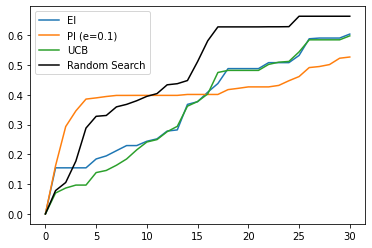

In [4]:
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ei)), label='EI')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_pi)), label='PI (e=0.1)')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_ucb)), label='UCB')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_rand)), label='Random Search', c='k')
plt.legend()
plt.plot()